In [1]:
import numpy as np
import pandas as pd
import vmlab

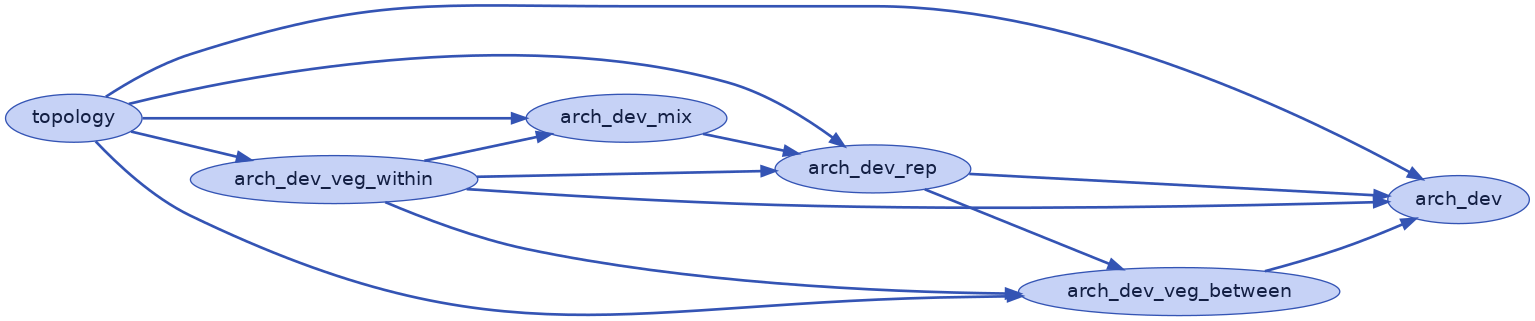

In [2]:
from vmlab.models import arch_dev_model
arch_dev_model.visualize()

In [3]:
start_date='2003-06-01'
end_date='2005-06-01'
setup = vmlab.create_setup(
    model=arch_dev_model,
    start_date=start_date,
    end_date=end_date,
    setup_toml='../share/setup/arch_dev_model.toml',
    current_cycle=3,
    input_vars={
        'topology__seed': 11
    },
    output_vars=None
)

In [4]:
ds_out = vmlab.run(setup, arch_dev_model)

             0% | initialize 

<AxesSubplot:>

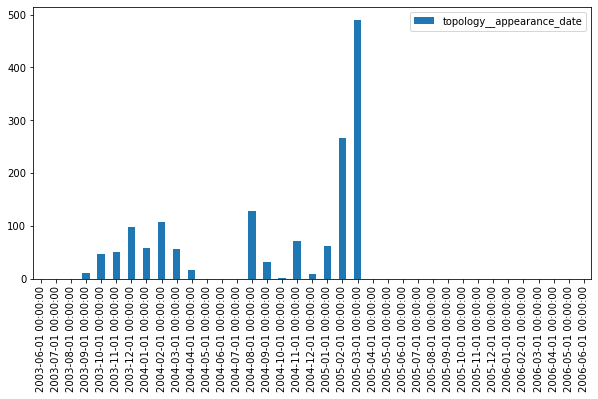

In [5]:
appearance_date = ds_out.topology__appearance_date.groupby(ds_out.topology__appearance_date)
appearance_date.count().to_dataframe().reindex(pd.date_range(start=start_date, end=end_date, freq='MS')).plot.bar(figsize=(10,5))

<AxesSubplot:>

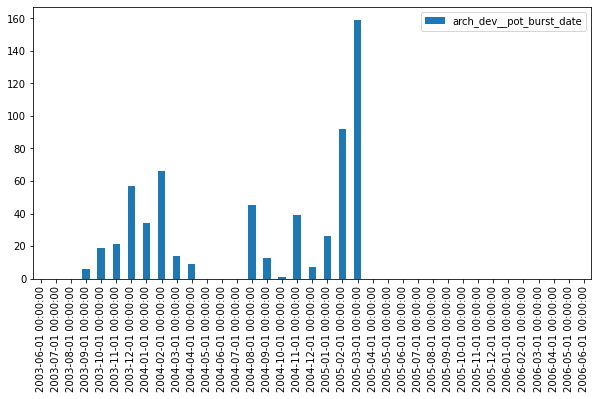

In [6]:
burst_date = ds_out.arch_dev__pot_burst_date.groupby(ds_out.arch_dev__pot_burst_date)
burst_date.count().to_dataframe().reindex(pd.date_range(start=start_date, end=end_date, freq='MS')).plot.bar(figsize=(10,5))

<AxesSubplot:xlabel='arch_dev__pot_flowering_date'>

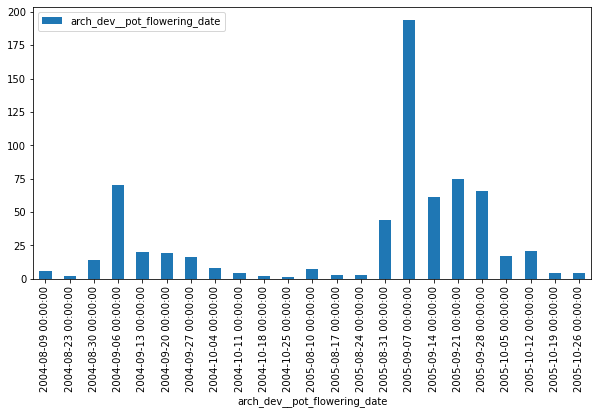

In [7]:
flowering_date = ds_out.arch_dev__pot_flowering_date.groupby(ds_out.arch_dev__pot_flowering_date)
flowering_date.count().to_dataframe().plot.bar(figsize=(10,5))

<AxesSubplot:xlabel='arch_dev__pot_nb_inflo'>

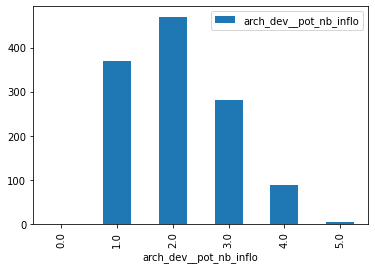

In [8]:
nb_inflo = ds_out.arch_dev__pot_nb_inflo.groupby(ds_out.arch_dev__pot_nb_inflo)
nb_inflo.sum().to_dataframe().plot.bar()

<AxesSubplot:xlabel='topology__cycle'>

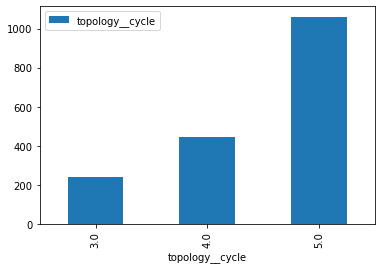

In [9]:
cycle = ds_out.topology__cycle.groupby(ds_out.topology__cycle)
cycle.count().to_dataframe().plot.bar()